# Flowers Classification Using Tensorflow and Image Augmentation

<i>Author:</i> <b>Harmeet Singh</b>

<i>Purpose:</i> <b>In this Colab we will classify images of flowers. We build an image classifier using tf.keras model.</b>


### Importing the Necessary Packages

In [13]:
# importing packages
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading the Data

In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [71]:
# specify the tensorflow dataset url
flowers_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# extract the current directory
cwd = os.getcwd()

# download the flowers zip to current working directory
flowers_zip_file = tf.keras.utils.get_file(origin = flowers_URL,
                                           fname = "flower_photos.tgz",
                                           extract = True,
                                           cache_dir = cwd)

# establish directory for unpacking the flowers images
base_dir = os.path.join(os.path.dirname(flowers_zip_file), 'flower_photos')



The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes:

In [34]:
# Labelling classes
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

### Train and Validation Split

In this section we split the flowers dataset to training and validation sets. Since the datasets are saved as folders of each flower class, we need to create rearrange and create folders for the train and validation dataset and then consisting of subfolders of each class.

In [72]:
# Creating Train and Validation Folders and splitting the data
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


For convenience, let us set up the path for the training and validation sets

In [73]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation

Using the **ImageDataGenerator** class we pass different transformations on our train images (e.g horizontal flips, rotations, zoom, width and height shifts) so that the model becomes good at generalizing and avoid overfitting.

#### Set Batch and Image Size

Below, we create a `batch_size` of 100 images and set a value to `IMG_SHAPE` such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [74]:
# Setting batch size and Image dimensions
batch_size = 100
IMG_SHAPE = 150

### Function for Plotting Augmented Images

In [75]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Image Augmentation & Visualization

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

In [79]:
# establish image augmentation parameters
image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     zoom_range= 0.5,
                                     horizontal_flip= True,
                                     rotation_range = 45,
                                     width_shift_range= 0.15,
                                     height_shift_range = 0.15)

# generating train images based on augmentation and batch sizes
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               class_mode = 'sparse')

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset.

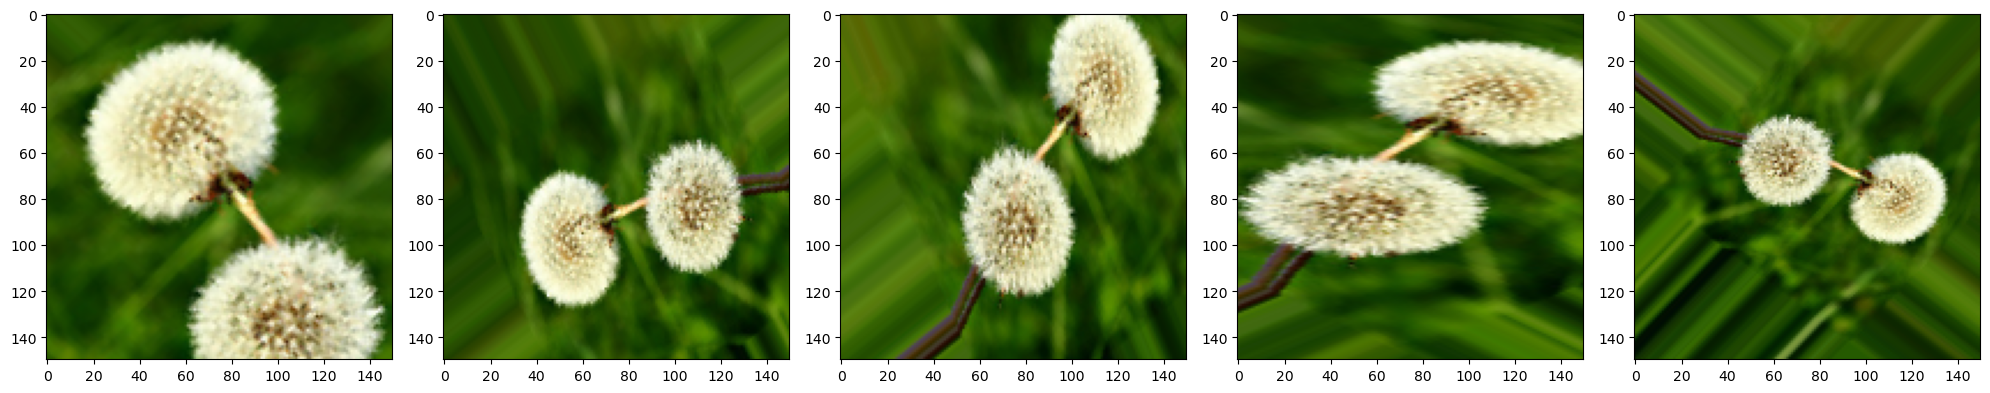

In [80]:
# Plotting a sample of augmented images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [81]:
# Image generation for the validation set
image_gen_val = ImageDataGenerator(rescale = 1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size = batch_size,
                                             directory = val_dir,
                                             shuffle = False,
                                             target_size = (IMG_SHAPE, IMG_SHAPE),
                                             class_mode = 'sparse')

Found 735 images belonging to 5 classes.


# Creating the CNN using tf.Keras

In [83]:
# initializing the model with the layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(len(classes), activation = 'softmax') # softmax for the final layer for classification
])

# Compile the Model

Using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, therefore, we pass the metrics argument too.

In [84]:
# Compiling the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

# Training the Model

Training the model using the **fit** function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for our model. We also Train the model for 100 epochs.

In [86]:
# set number of epochs
epochs = 100

# train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(val_data_gen.n) / float(batch_size))
)

Epoch 1/100
30/30 [==============================] - 16s 518ms/step - loss: 1.1773 - accuracy: 0.5121 - val_loss: 1.0946 - val_accuracy: 0.5371
Epoch 2/100
30/30 [==============================] - 16s 514ms/step - loss: 1.0906 - accuracy: 0.5652 - val_loss: 1.0111 - val_accuracy: 0.5986
Epoch 3/100
30/30 [==============================] - 16s 514ms/step - loss: 1.0023 - accuracy: 0.5983 - val_loss: 1.0092 - val_accuracy: 0.6043
Epoch 4/100
30/30 [==============================] - 16s 533ms/step - loss: 0.9435 - accuracy: 0.6310 - val_loss: 0.9291 - val_accuracy: 0.6386
Epoch 5/100
30/30 [==============================] - 16s 524ms/step - loss: 0.9407 - accuracy: 0.6256 - val_loss: 0.9789 - val_accuracy: 0.6286
Epoch 6/100
30/30 [==============================] - 16s 525ms/step - loss: 0.8960 - accuracy: 0.6535 - val_loss: 0.9113 - val_accuracy: 0.6586
Epoch 7/100
30/30 [==============================] - 16s 539ms/step - loss: 0.8961 - accuracy: 0.6395 - val_loss: 0.8591 - val_accuracy:

# Plot Training and Validation Graphs.

In the cell below, we plot the training and validation accuracy / loss graphs.

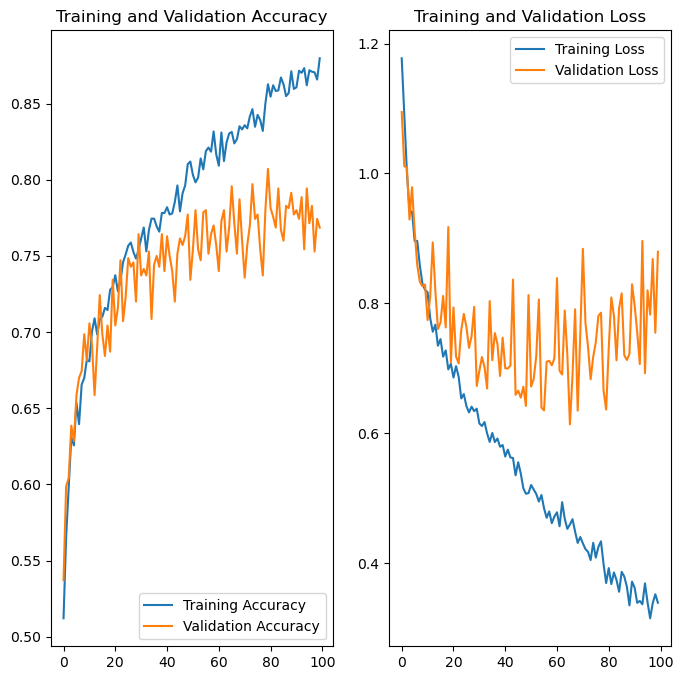

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


From the plots above, we note that the model has a train accuracy close to 88% after 100 epochs but the validaton accuracy does not change much after around 77% (~ 40 epochs). This is a classical example of overfitting and can be solved by implementing Early Stopping. We will address in the next section.

# Re-run with Early Stopping



In [103]:
# set callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [104]:
# initializing the model with the layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(len(classes), activation = 'softmax') # softmax for the final layer for classification
])

In [105]:
# Compiling the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [106]:
# set number of epochs
epochs = 100

# train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(val_data_gen.n) / float(batch_size)),
    callbacks=[callback]
)

Epoch 1/100
30/30 [==============================] - 17s 553ms/step - loss: 1.5119 - accuracy: 0.3359 - val_loss: 1.2160 - val_accuracy: 0.4914
Epoch 2/100
30/30 [==============================] - 18s 597ms/step - loss: 1.1783 - accuracy: 0.5046 - val_loss: 1.0845 - val_accuracy: 0.5514
Epoch 3/100
30/30 [==============================] - 20s 669ms/step - loss: 1.0671 - accuracy: 0.5755 - val_loss: 1.0750 - val_accuracy: 0.6086
Epoch 4/100
30/30 [==============================] - 19s 630ms/step - loss: 0.9792 - accuracy: 0.6024 - val_loss: 1.0229 - val_accuracy: 0.6357
Epoch 5/100
30/30 [==============================] - 16s 523ms/step - loss: 0.9406 - accuracy: 0.6259 - val_loss: 0.9673 - val_accuracy: 0.6457
Epoch 6/100
30/30 [==============================] - 16s 511ms/step - loss: 0.9186 - accuracy: 0.6446 - val_loss: 0.9022 - val_accuracy: 0.6571
Epoch 7/100
30/30 [==============================] - 16s 519ms/step - loss: 0.8861 - accuracy: 0.6562 - val_loss: 1.0218 - val_accuracy:

# Plot Training and Validation Graphs (with Early Stopping).

In the cell below, we plot the training and validation accuracy / loss graphs.

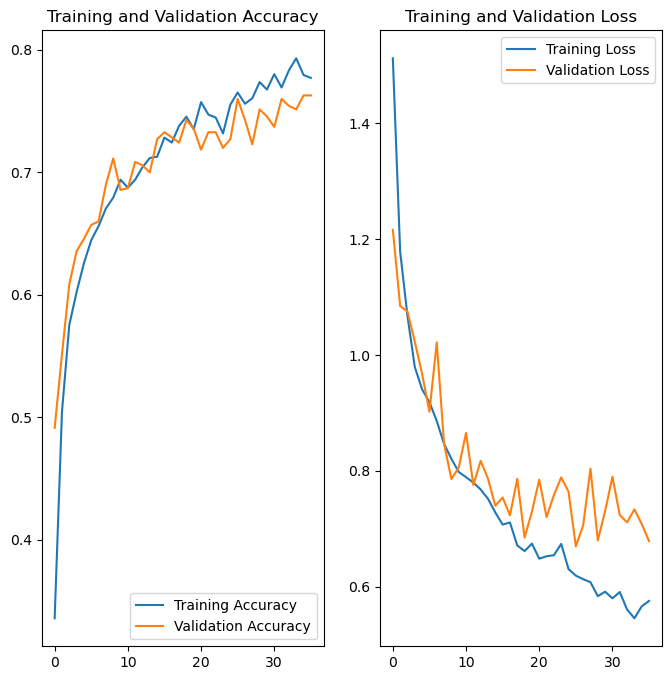

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


With Early Stopping, the model stops at 36 epochs with an accuracy of 78% on both the train and validation sets. The model can be further enhanced by enhancing the image augmentation, dropout ratio and increasing the layers in the CNN.

--- End of Project ---